In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()
df

,Autor,Tekst
0,1,"padajte, braćo, plin'te u krvi! ostav'te sela ..."
1,1,"mudraci su prinosili dara: smirnu, zlato, caru..."
2,1,mnogi me je dosad zapitkiv’o: sa čega sam srca...
3,1,"ja sam stena, o koju se zloba mori, svetska ču..."
4,1,kroz ponoć nemu i gusto granje vidi se zvezda ...
...,...,...
133,2,"ostale su za mnom bašte jorgovana, sjaj prolje..."
134,2,"popô si se sred milina, dvor ti zlato, svila k..."
135,13,već sanduk zatvaraju čvrsto da večno budeš ple...
136,13,"ne pitaj me o bosforu više, ja ti ne znam odgo..."


,Autor,Tekst
0,1,"padajte, braćo, plin'te u krvi! ostav'te sela ..."
1,1,"mudraci su prinosili dara: smirnu, zlato, caru..."
2,1,mnogi me je dosad zapitkiv’o: sa čega sam srca...
3,1,"ja sam stena, o koju se zloba mori, svetska ču..."
4,1,kroz ponoć nemu i gusto granje vidi se zvezda ...
...,...,...
133,2,"ostale su za mnom bašte jorgovana, sjaj prolje..."
134,2,"popô si se sred milina, dvor ti zlato, svila k..."
135,13,već sanduk zatvaraju čvrsto da večno budeš ple...
136,13,"ne pitaj me o bosforu više, ja ti ne znam odgo..."


Tokenizacija reci i recenica


In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

True

In [4]:
class LangVars(PunktLanguageVars):
    sent_end_chars = ('.', '!', '?', ';', ":", "...", '..','…')
custom_sent_tokenizer = PunktSentenceTokenizer(lang_vars=LangVars())
df['Recenice'] = df['Tekst'].apply(custom_sent_tokenizer.tokenize)

In [5]:
custom_tokenizer = RegexpTokenizer(r'\w+[\'\’]*\w*|[^\w\s]')
df['Tokeni'] = df['Tekst'].apply(custom_tokenizer.tokenize)

In [6]:
punctuation = r'[^\w\s]'
def remove_punctuation(tokens): 
    filtered_tokens = [word for word in tokens if not re.match(punctuation, word)]
    return filtered_tokens

df['Filtrirani tokeni'] = df['Tokeni'].apply(remove_punctuation)

In [7]:
from nltk import FreqDist

In [8]:
all_words = [word for words in df['Filtrirani tokeni'] for word in words]
fdist = FreqDist(all_words)
stopwords = [word for word, count in fdist.items() if count > 50 or (len(word) in (1,2,3) and count > 20)]

In [9]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens

#df['Filtrirani tokeni'] = df['Filtrirani tokeni'].apply(remove_stopwords)

In [10]:
df.to_csv('stilometrija_medjukorak.csv', index=False)

Podela podataka na trening i test

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df[['Tekst', 'Recenice', 'Tokeni','Filtrirani tokeni']]
y = df['Autor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Stilometrijske analize

In [13]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [14]:
def average_word_length(words):
    return sum(len(word) for word in words) / len(words)

df_train['Duzina reci'] = df_train['Filtrirani tokeni'].apply(average_word_length)
df_test['Duzina reci'] = df_test['Filtrirani tokeni'].apply(average_word_length)


In [15]:
df_avgWordLength = df_train.groupby('Autor')['Duzina reci'].mean().reset_index()

In [16]:
import matplotlib.pyplot as plt


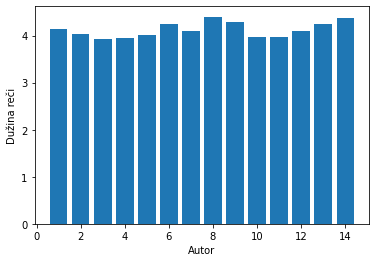

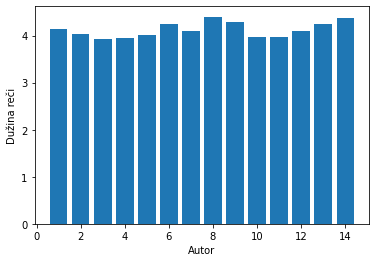

In [17]:
plt.bar(df_avgWordLength['Autor'], df_avgWordLength['Duzina reci'])
plt.xlabel('Autor')
plt.ylabel('Dužina reči')
plt.show()

In [18]:
def average_sentence_length(sentences):
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

df_train['Duzina recenica'] = df_train['Recenice'].apply(average_sentence_length)
df_test['Duzina recenica'] = df_test['Recenice'].apply(average_sentence_length)


In [19]:
df_avgSentLength = df_train.groupby('Autor')['Duzina recenica'].mean().reset_index()


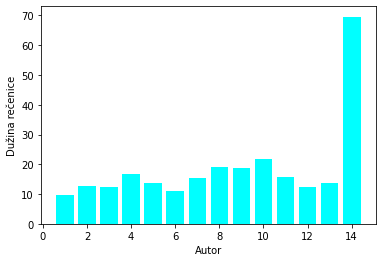

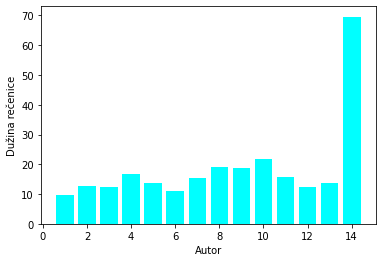

In [20]:
plt.bar(df_avgSentLength['Autor'], df_avgSentLength['Duzina recenica'], color='cyan')
plt.xlabel('Autor')
plt.ylabel('Dužina rečenice')
plt.show()

In [21]:
def text_length(words):
    return sum(len(word) for word in words)
df_train['Duzina teksta'] = df_train['Tokeni'].apply(text_length)
df_test['Duzina teksta'] = df_test['Tokeni'].apply(text_length)

In [22]:
df_avgTextLength = df_train.groupby('Autor')['Duzina teksta'].mean().reset_index()


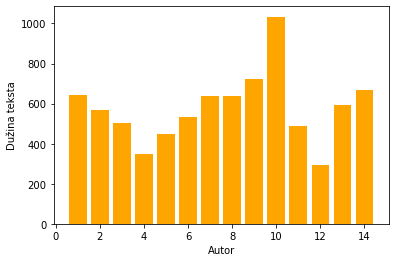

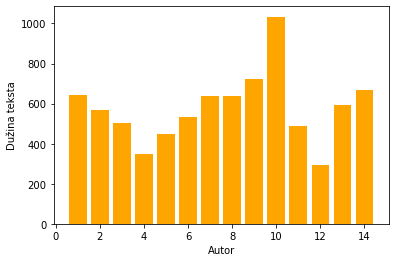

In [23]:
plt.bar(df_avgTextLength['Autor'], df_avgTextLength['Duzina teksta'], color='orange')
plt.xlabel('Autor')
plt.ylabel('Dužina teksta')
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
model = RandomForestClassifier(max_depth=5, min_samples_split=15, n_estimators=300)

model.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']], df_train['Autor'])

y_train_pred_rf = model.predict(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])

# Predikcije na test skup
y_test_pred_rf = model.predict(df_test[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])

print('Random Forest - Trening skup:\n')
print(f'Tačnost: {accuracy_score(df_train["Autor"], y_train_pred_rf)}')
print(f'F1 ocena: {f1_score(df_train["Autor"], y_train_pred_rf, average="weighted")}')
print(f'Odziv: {recall_score(df_train["Autor"], y_train_pred_rf, average="weighted")}\n')

print('Random Forest - Test skup:\n')
print(f'Tačnost: {accuracy_score(df_test["Autor"], y_test_pred_rf)}')
print(f'F1 ocena: {f1_score(df_test["Autor"], y_test_pred_rf, average="weighted")}')
print(f'Odziv: {recall_score(df_test["Autor"], y_test_pred_rf, average="weighted")}\n')


Random Forest - Trening skup:

Tačnost: 0.6666666666666666
F1 ocena: 0.6468440563268149
Odziv: 0.6666666666666666

Random Forest - Test skup:

Tačnost: 0.21428571428571427
F1 ocena: 0.18274318274318274
Odziv: 0.21428571428571427

Random Forest - Trening skup:

Tačnost: 0.6666666666666666
F1 ocena: 0.6468440563268149
Odziv: 0.6666666666666666

Random Forest - Test skup:

Tačnost: 0.21428571428571427
F1 ocena: 0.18274318274318274
Odziv: 0.21428571428571427



In [25]:
from sklearn.naive_bayes import MultinomialNB

classifierMB = MultinomialNB()

# Treniranje modela na trening skupu
classifierMB.fit(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']], df_train['Autor'])

# Predikcije na trening skupu
y_train_pred_MB = classifierMB.predict(df_train[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])

# Predikcije na test skupu
y_test_pred_MB = classifierMB.predict(df_test[['Duzina reci', 'Duzina recenica', 'Duzina teksta']])

# Evaluacione metrike za Multinomial Bajes
print('Multinomial Bajes - Trening skup:\n')
print(f'Tačnost: {accuracy_score(df_train["Autor"], y_train_pred_MB)}')
print(f'F1 ocena: {f1_score(df_train["Autor"], y_train_pred_MB, average="weighted")}')
print(f'Odziv: {recall_score(df_train["Autor"], y_train_pred_MB, average="weighted")}\n')

print('Multinomial Bajes - Test skup:\n')
print(f'Tačnost: {accuracy_score(df_test["Autor"], y_test_pred_MB)}')
print(f'F1 ocena: {f1_score(df_test["Autor"], y_test_pred_MB, average="weighted")}')
print(f'Odziv: {recall_score(df_test["Autor"], y_test_pred_MB, average="weighted")}\n')

Multinomial Bajes - Trening skup:

Tačnost: 0.16666666666666666
F1 ocena: 0.10788343659735848
Odziv: 0.16666666666666666

Multinomial Bajes - Test skup:

Tačnost: 0.14285714285714285
F1 ocena: 0.08154170759212775
Odziv: 0.14285714285714285

Multinomial Bajes - Trening skup:

Tačnost: 0.16666666666666666
F1 ocena: 0.10788343659735848
Odziv: 0.16666666666666666

Multinomial Bajes - Test skup:

Tačnost: 0.14285714285714285
F1 ocena: 0.08154170759212775
Odziv: 0.14285714285714285

